In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-sdn/dataset_sdn.csv


In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn import metrics

data = pd.read_csv('/kaggle/input/dataset-sdn/dataset_sdn.csv')

data.info()

data.isna().sum()

data.dropna(inplace=True)
data.duplicated().sum()

data2 = data.drop_duplicates()
data2.isna().sum()

data2.info()
data2.groupby('label').size()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104345 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           104345 non-null  int64  
 1   switch       104345 non-null  int64  
 2   src          104345 non-null  object 
 3   dst          104345 non-null  object 
 4   pktcount     104345 non-null  int64  
 5   bytecount    104345 non-null  int64  
 6   dur          104345 non-null  int64  
 7   dur_nsec     104345 non-null  int64  
 8   tot_dur      104345 non-null  float64
 9   flows        104345 non-null  int64  
 10  packetins    104345 non-null  int64  
 11  pktperflow   104345 non-null  int64  
 12  byteperflow  104345 non-null  int64  
 13  pktrate      104345 non-null  int64  
 14  Pairflow     104345 non-null  int64  
 15  Protocol     104345 non-null  object 
 16  port_no      104345 non-null  int64  
 17  tx_bytes     104345 non-null  int64  
 18  rx_bytes     104345 non-

label
0    61022
1    37726
dtype: int64

Numeric Columns:
Index(['dt', 'switch', 'pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur',
       'flows', 'packetins', 'pktperflow', 'byteperflow', 'pktrate',
       'Pairflow', 'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps',
       'tot_kbps', 'label'],
      dtype='object') 

Object (Categorical) Columns:
Index(['src', 'dst', 'Protocol'], dtype='object') 

Total Number of Numeric Columns: 20
Total Number of Object Columns: 3


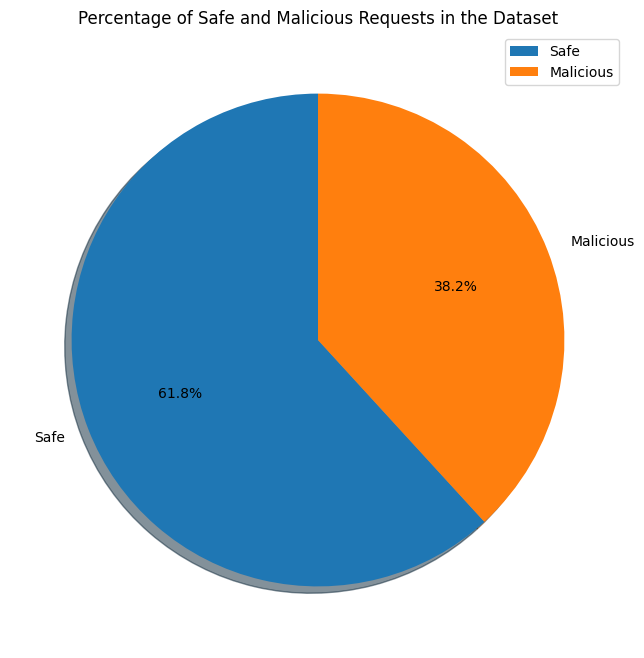

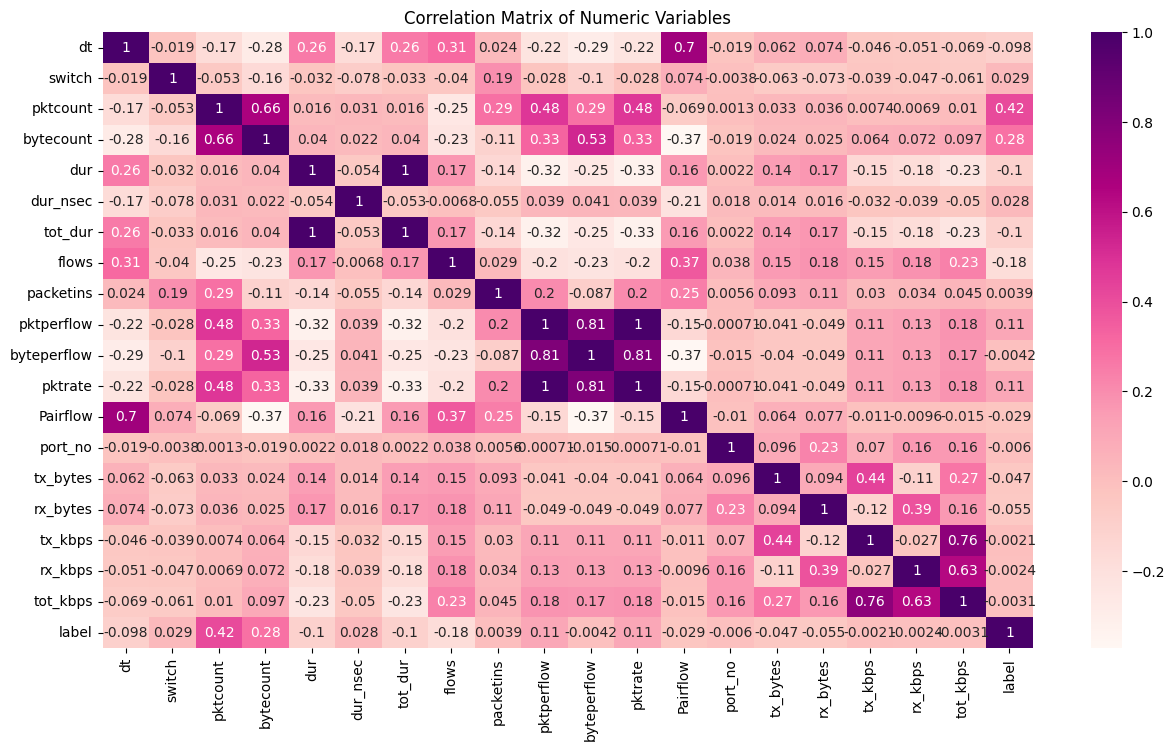

,dt,src,dst,pktcount,bytecount,pktperflow,byteperflow,pktrate,Pairflow,Protocol,tx_kbps,rx_kbps,tot_kbps,label
0,11425,10.0.0.1,10.0.0.8,45304,48294064,13535,14428310,451,0,UDP,0,0.0,0.0,0
1,11605,10.0.0.1,10.0.0.8,126395,134737070,13531,14424046,451,0,UDP,0,0.0,0.0,0
2,11425,10.0.0.2,10.0.0.8,90333,96294978,13534,14427244,451,0,UDP,0,0.0,0.0,0
3,11425,10.0.0.2,10.0.0.8,90333,96294978,13534,14427244,451,0,UDP,0,0.0,0.0,0
4,11425,10.0.0.2,10.0.0.8,90333,96294978,13534,14427244,451,0,UDP,0,0.0,0.0,0


In [36]:
# Separate numeric and object (categorical) columns
numeric_df = data2.select_dtypes(include=['int64', 'float64'])
object_df = data2.select_dtypes(include=['object'])
numeric_cols = numeric_df.columns
object_cols = object_df.columns

# Print information about column types
print('Numeric Columns:')
print(numeric_cols, '\n')
print('Object (Categorical) Columns:')
print(object_cols, '\n')
print(f'Total Number of Numeric Columns: {len(numeric_cols)}')
print(f'Total Number of Object Columns: {len(object_cols)}')

# Plot the distribution of safe vs malicious requests
labels = ["Safe", "Malicious"]
sizes = [
    dict(data2.label.value_counts())[0],  # Count of safe requests
    dict(data2.label.value_counts())[1],  # Count of malicious requests
]
plt.figure(figsize=(13, 8))
plt.pie(
    sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90
)
plt.legend(["Safe", "Malicious"])
plt.title('Percentage of Safe and Malicious Requests in the Dataset')
plt.show()

# Calculate and visualize the correlation matrix for numeric columns
numeric_data = data2.select_dtypes(include='number')
correlation_matrix = numeric_data.corr()

# Plot the heatmap for correlations
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, ax=ax, cmap="RdPu")
plt.title('Correlation Matrix of Numeric Variables')
plt.show()

# Drop irrelevant columns and create a new dataset
columns_to_drop = [
    'switch', 'dur', 'dur_nsec', 'tot_dur', 'flows', 
    'packetins', 'port_no', 'tx_bytes', 'rx_bytes'
]
data_new = data2.drop(columns=columns_to_drop).copy()

# Display the modified dataset
data_new.head()


In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

# Assuming data_new is your DataFrame
X = data_new.drop(columns=['label']).copy()

# Specify the categorical columns
categorical_columns = ['src', 'dst', 'Protocol']

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)
    ],
    remainder='passthrough'
)

# Create a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_encoded = pipeline.fit_transform(X)

# Get the column names
encoded_column_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_columns)
numeric_columns = X.columns.difference(categorical_columns)
column_names = list(encoded_column_names) + list(numeric_columns)

# Create a DataFrame with the updated column names
X = pd.DataFrame(X_encoded, columns=column_names)

# Display the first few rows of the transformed DataFrame
print(X.head())


   src_10.0.0.1  src_10.0.0.10  src_10.0.0.11  src_10.0.0.12  src_10.0.0.13  \
0           1.0            0.0            0.0            0.0            0.0   
1           1.0            0.0            0.0            0.0            0.0   
2           0.0            0.0            0.0            0.0            0.0   
3           0.0            0.0            0.0            0.0            0.0   
4           0.0            0.0            0.0            0.0            0.0   

   src_10.0.0.14  src_10.0.0.15  src_10.0.0.16  src_10.0.0.17  src_10.0.0.18  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   ...  Pairflow  bytecount  byteperflow    

In [12]:
X

,src_10.0.0.1,src_10.0.0.10,src_10.0.0.11,src_10.0.0.12,src_10.0.0.13,src_10.0.0.14,src_10.0.0.15,src_10.0.0.16,src_10.0.0.17,src_10.0.0.18,...,Pairflow,bytecount,byteperflow,dt,pktcount,pktperflow,pktrate,rx_kbps,tot_kbps,tx_kbps
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11425.0,45304.0,48294064.0,13535.0,14428310.0,451.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11605.0,126395.0,134737070.0,13531.0,14424046.0,451.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11425.0,90333.0,96294978.0,13534.0,14427244.0,451.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11425.0,90333.0,96294978.0,13534.0,14427244.0,451.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11425.0,90333.0,96294978.0,13534.0,14427244.0,451.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5262.0,79.0,7742.0,29.0,2842.0,0.0,0.0,1.0,1.0,2.0
98744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5262.0,79.0,7742.0,29.0,2842.0,0.0,0.0,1.0,1.0,2.0
98745,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5262.0,31.0,3038.0,30.0,2940.0,1.0,0.0,0.0,0.0,0.0
98746,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5262.0,31.0,3038.0,30.0,2940.0,1.0,0.0,1.0,1.0,2.0


In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Assuming data_new is your DataFrame
y = data_new['label']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [38]:
class Model:
    global y
    def __init__(self, data):
        self.data = data
        X = preprocessing.StandardScaler().fit(self.data).transform(self.data)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, random_state=42, test_size=0.3)
    
    def LogisticRegression(self):
        """Train and evaluate Logistic Regression with multiple solvers."""
        solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
        start_time = time.time()
        best_solver, best_model, best_accuracy = None, None, 0

        print("Training Logistic Regression with different solvers...")
        for solver in solvers:
            try:
                # Train the model
                model = LogisticRegression(C=0.03, solver=solver, max_iter=1000).fit(self.X_train, self.y_train)
                predictions = model.predict(self.X_test)
                accuracy = accuracy_score(self.y_test, predictions)

                # Update the best model and solver if accuracy improves
                if accuracy > best_accuracy:
                    best_solver, best_model, best_accuracy = solver, model, accuracy

                print(f"Solver: {solver} | Accuracy: {accuracy * 100:.2f}%")
            except Exception as e:
                print(f"Solver: {solver} failed with error: {e}")

        if best_model:
            # Display the best solver and accuracy
            print("\nBest Logistic Regression Model:")
            print(f"Solver: {best_solver}")
            print(f"Accuracy: {best_accuracy * 100:.2f}%")
            print("\nClassification Report:")
            print(classification_report(self.y_test, best_model.predict(self.X_test)))
        else:
            print("All solvers failed. Please check the input data and parameters.")

        print(f"Execution Time: {time.time() - start_time:.2f} seconds\n")

    def SupportVectorMachine(self):
        """Train and evaluate SVM with manual hyperparameter tuning for faster execution."""
        import warnings

        start_time = time.time()
        print("Training Support Vector Machine with manual hyperparameter tuning...")

        # Suppress warnings from SVC
        warnings.filterwarnings("ignore", category=UserWarning)

        # Parameters for tuning
        kernels = ['rbf']
        C_values = [1, 10]
        gamma_values = ['scale', 'auto']
        best_accuracy, best_params = 0, {}

        for kernel in kernels:
            for C in C_values:
                for gamma in gamma_values:
                    try:
                        # Train the model with the current parameters
                        model = svm.SVC(kernel=kernel, C=C, gamma=gamma).fit(self.X_train, self.y_train)
                        predictions = model.predict(self.X_test)
                        accuracy = accuracy_score(self.y_test, predictions)

                        # Update the best parameters if accuracy improves
                        if accuracy > best_accuracy:
                            best_accuracy = accuracy
                            best_params = {'kernel': kernel, 'C': C, 'gamma': gamma}

                    except Exception as e:
                        print(f"Training failed for kernel={kernel}, C={C}, gamma={gamma} with error: {e}")

        # Train the final model with the best parameters
        if best_params:
            print("\nBest SVM Model:")
            print(f"Parameters: {best_params}")
            final_model = svm.SVC(**best_params).fit(self.X_train, self.y_train)
            predictions = final_model.predict(self.X_test)
            print(f"Accuracy: {best_accuracy * 100:.2f}%")
            print("\nClassification Report:")
            print(classification_report(self.y_test, predictions))
        else:
            print("All parameter combinations failed.")

        print(f"Execution Time: {time.time() - start_time:.2f} seconds\n")


    def KNearestNeighbor(self):
        """Train and evaluate KNN with manual hyperparameter tuning for faster execution."""
        start_time = time.time()
        print("Training K-Nearest Neighbor with manual hyperparameter tuning...")

        # Parameters for tuning
        n_neighbors_values = [3, 5, 7]  # Fewer neighbor values for efficiency
        weights_values = ['uniform', 'distance']  # Common weighting methods
        best_accuracy, best_params = 0, {}
    
        for n_neighbors in n_neighbors_values:
            for weights in weights_values:
                try:
                    # Train the model with the current parameters
                    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights).fit(self.X_train, self.y_train)
                    predictions = model.predict(self.X_test)
                    accuracy = accuracy_score(self.y_test, predictions)

                    # Update the best parameters if accuracy improves
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_params = {'n_neighbors': n_neighbors, 'weights': weights}

                except Exception as e:
                    print(f"Training failed for n_neighbors={n_neighbors}, weights={weights} with error: {e}")

        # Train the final model with the best parameters
        if best_params:
            print("\nBest KNN Model:")
            print(f"Parameters: {best_params}")
            final_model = KNeighborsClassifier(**best_params).fit(self.X_train, self.y_train)
            predictions = final_model.predict(self.X_test)
            print(f"Accuracy: {best_accuracy * 100:.2f}%")
            print("\nClassification Report:")
            print(classification_report(self.y_test, predictions))
        else:
            print("All parameter combinations failed.")

        print(f"Execution Time: {time.time() - start_time:.2f} seconds\n")

        
    def DecisionTree(self):
        """Train and evaluate Decision Tree with manual hyperparameter tuning for faster execution."""
        start_time = time.time()
        print("Training Decision Tree with manual hyperparameter tuning...")

        # Parameters for tuning
        criterions = ['gini', 'entropy']  # Commonly used split criteria
        max_depth_values = [3, 5, 7]  # Focus on a few reasonable depth values
        best_accuracy, best_params = 0, {}

        for criterion in criterions:
            for max_depth in max_depth_values:
                try:
                    # Train the model with the current parameters
                    model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth).fit(self.X_train, self.y_train)
                    predictions = model.predict(self.X_test)
                    accuracy = accuracy_score(self.y_test, predictions)

                    # Update the best parameters if accuracy improves
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_params = {'criterion': criterion, 'max_depth': max_depth}

                except Exception as e:
                    print(f"Training failed for criterion={criterion}, max_depth={max_depth} with error: {e}")

        # Train the final model with the best parameters
        if best_params:
            print("\nBest Decision Tree Model:")
            print(f"Parameters: {best_params}")
            final_model = DecisionTreeClassifier(**best_params).fit(self.X_train, self.y_train)
            predictions = final_model.predict(self.X_test)
            print(f"Accuracy: {best_accuracy * 100:.2f}%")
            print("\nClassification Report:")
            print(classification_report(self.y_test, predictions))
        else:
            print("All parameter combinations failed.")

        print(f"Execution Time: {time.time() - start_time:.2f} seconds\n")
    
        
    def RandomForest(self):
        """Train and evaluate Random Forest with manual hyperparameter tuning for faster execution."""
        start_time = time.time()
        print("Training Random Forest with manual hyperparameter tuning...")

        # Parameters for tuning
        n_estimators_values = [100, 200]  # Reasonable number of trees
        max_depth_values = [None, 10, 20]  # Default (None) and practical depth values
        best_accuracy, best_params = 0, {}

        for n_estimators in n_estimators_values:
            for max_depth in max_depth_values:
                try:
                    # Train the model with the current parameters
                    model = RandomForestClassifier(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        random_state=42,
                        n_jobs=-1  # Parallel processing
                    ).fit(self.X_train, self.y_train)
                    predictions = model.predict(self.X_test)
                    accuracy = accuracy_score(self.y_test, predictions)

                    # Update the best parameters if accuracy improves
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_params = {'n_estimators': n_estimators, 'max_depth': max_depth}

                except Exception as e:
                    print(f"Training failed for n_estimators={n_estimators}, max_depth={max_depth} with error: {e}")

        # Train the final model with the best parameters
        if best_params:
            print("\nBest Random Forest Model:")
            print(f"Parameters: {best_params}")
            final_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1).fit(self.X_train, self.y_train)
            predictions = final_model.predict(self.X_test)
            print(f"Accuracy: {best_accuracy * 100:.2f}%")
            print("\nClassification Report:")
            print(classification_report(self.y_test, predictions))
        else:
            print("All parameter combinations failed.")

        print(f"Execution Time: {time.time() - start_time:.2f} seconds\n")

        
    def XGBoost(self):
        """Train and evaluate XGBoost with hyperparameter tuning."""
        start_time = time.time()
        print("Training XGBoost with hyperparameter tuning...")

        # Parameter grid for hyperparameter tuning
        param_grid = {
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'n_estimators': [100, 200, 300]
        }

        # Initialize GridSearchCV
        xgb = XGBClassifier(eval_metric='error', objective='binary:logistic', use_label_encoder=False)
        grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=2)

        # Train the model
        try:
            grid_search.fit(self.X_train, self.y_train)
            best_params = grid_search.best_params_
            best_model = grid_search.best_estimator_
            predictions = best_model.predict(self.X_test)
            accuracy = accuracy_score(self.y_test, predictions)

            # Print the best parameters and results
            print("\nBest XGBoost Model:")
            print(f"Parameters: {best_params}")
            print(f"Accuracy: {accuracy * 100:.2f}%")
            print("\nClassification Report:")
            print(classification_report(self.y_test, predictions))
        except Exception as e:
            print(f"XGBoost training failed with error: {e}")

        print(f"Execution Time: {time.time() - start_time:.2f} seconds\n")
  



In [20]:
X = pd.get_dummies(X)

y


array([0, 0, 0, ..., 0, 0, 0])

In [21]:
M = Model(X)

In [27]:
M.LogisticRegression()

Training Logistic Regression with different solvers...
Solver: newton-cg | Accuracy: 80.08%
Solver: lbfgs | Accuracy: 80.08%
Solver: liblinear | Accuracy: 80.06%
Solver: sag | Accuracy: 80.08%
Solver: saga | Accuracy: 80.08%

Best Logistic Regression Model:
Solver: newton-cg
Accuracy: 80.08%

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.85     18270
           1       0.78      0.67      0.72     11355

    accuracy                           0.80     29625
   macro avg       0.80      0.78      0.78     29625
weighted avg       0.80      0.80      0.80     29625

Execution Time: 11.51 seconds



In [34]:
M.XGBoost()

Training XGBoost with hyperparameter tuning...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   2.7s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   1.5s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   1.7s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=300; total time=   4.1s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time=   2.2s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=   3.4s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   1.3s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   1.3s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   2.2s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=   3.1s
[

In [29]:
M.DecisionTree()

Training Decision Tree with manual hyperparameter tuning...

Best Decision Tree Model:
Parameters: {'criterion': 'gini', 'max_depth': 7}
Accuracy: 97.92%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     18270
           1       0.95      0.99      0.97     11355

    accuracy                           0.98     29625
   macro avg       0.97      0.98      0.98     29625
weighted avg       0.98      0.98      0.98     29625

Execution Time: 2.10 seconds



In [31]:
M.KNearestNeighbor()

Training K-Nearest Neighbor with manual hyperparameter tuning...

Best KNN Model:
Parameters: {'n_neighbors': 5, 'weights': 'distance'}
Accuracy: 99.48%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18270
           1       0.99      0.99      0.99     11355

    accuracy                           0.99     29625
   macro avg       0.99      0.99      0.99     29625
weighted avg       0.99      0.99      0.99     29625

Execution Time: 46.87 seconds



In [35]:
M.RandomForest()

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Random Forest Accuracy: 99.99%
########################################################################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18270
           1       1.00      1.00      1.00     11355

    accuracy                           1.00     29625
   macro avg       1.00      1.00      1.00     29625
weighted avg       1.00      1.00      1.00     29625

Execution Time: 17.49 seconds
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   2.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   3.3s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=   3.0s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=300; total time=   4.2s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=   3.4s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=300; total time=   4.9s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimat

In [33]:
M.SupportVectorMachine()

Training Support Vector Machine with manual hyperparameter tuning...
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   2.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   3.7s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=   2.9s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=300; total time=   4.3s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time=   4.2s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=300; total time=   4.9s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   2.3s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   1.6s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   2.8s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=300; total time=   4.2s
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time=   3.4s
[CV] END ...learning_rate=0.1, max_depth